In [1]:
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Dependencises Installation

In [2]:
import re
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

In [3]:
urls = ["https://sanctionssearch.ofac.treas.gov/","https://home.treasury.gov/","https://www.thomsonreuters.com/","https://verafin.com/solution/","https://www.swift.com/","https://anti-fraud.ec.europa.eu/index_en","https://www.kroll.com/","https://learn.seon.io/"]

### For each URL, look for all href elements.

In [4]:
all_href = {}

for url in urls:
    temp_href = []
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    for a in soup.find_all('a', href=True):
        if a['href']!='':
            temp_href.append(a['href'])
    all_href[url]=list(set(temp_href))

In [5]:
total_href = 0
for url in all_href:
    print(url," = ", len(all_href[url]))
    total_href+=len(all_href[url])
print("total_href = ",total_href)

https://sanctionssearch.ofac.treas.gov/  =  11
https://home.treasury.gov/  =  289
https://www.thomsonreuters.com/  =  121
https://verafin.com/solution/  =  0
https://www.swift.com/  =  208
https://anti-fraud.ec.europa.eu/index_en  =  83
https://www.kroll.com/  =  107
https://learn.seon.io/  =  4
total_href =  823



### Out of these hrefs, filter out first 10 which start with http (or https) and those which do not. That is they have format href=”http://…” or href=https://......”

In [6]:
filtered_href=[]
for url in all_href:
    for href in all_href[url]:
        if href.lower().startswith(('http://', 'https://')):
            if len(filtered_href)==10:
                break
            filtered_href.append(href)
print("filtered_href = ", filtered_href)

filtered_href =  ['https://home.treasury.gov/policy-issues/financial-sanctions/consolidated-sanctions-list-data-files', 'https://home.treasury.gov/policy-issues/financial-sanctions/faqs/287', 'https://home.treasury.gov/policy-issues/financial-sanctions/specially-designated-nationals-list-data-formats-data-schemas', 'https://home.treasury.gov/policy-issues/financial-sanctions/specially-designated-nationals-list-sdn-list/program-tag-definitions-for-ofac-sanctions-lists', 'https://home.treasury.gov/policy-issues/office-of-foreign-assets-control-sanctions-programs-and-information', 'http://www.usajobs.gov/', 'https://home.treasury.gov/subfooter/site-policies-and-notices', 'https://www.irs.gov/forms-pubs/about-form-941', 'https://home.treasury.gov/utility/languages/alrbyt-arabic', 'https://www.treasury.gov/auctions/irs/index.html']


### For each href which starts with http or https, find all links which are valid (which return http status code 200 and those which are not valid). Save as a CSV file.

In [ ]:
all_valid = {"url":[],"valid_href":{}} 
for url in list(all_href.keys()):
    for href in all_href[url]:
        if href.lower().startswith(('http://', 'https://')):
            response = requests.get(href)
            if response.status_code==200:
                all_valid["valid_href"][href] = "Valid"
                all_valid["url"].append(url)
            else:
                all_valid["valid_href"][href] = "Invalid"
                all_valid["url"].append(url)
                print(len(all_valid["url"]),len(all_valid["valid_href"]))
                
df =pd.DataFrame({"url":all_valid["url"],"href":list(all_valid["valid_href"].keys()),"Status":list(all_valid["valid_href"].values())})
df.to_csv("valid_href.csv",index=False)

### Handle those cases where a website does not respond within 20 seconds ( configurable) ( Nice to have, leave if you have no time).

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
timeout=20
all_valid = {"url":[],"href":[],"status":[]} 
for url in list(all_href.keys()):
    for href in all_href[url]:
        if href.lower().startswith(('http://', 'https://')):
            try:
                response = requests.get(href,timeout=timeout)
                if response.status_code==200:
                    all_valid["url"].append(url)
                    all_valid["href"].append(href)
                    all_valid["status"].append("Valid")
                else:
                    all_valid["url"].append(url)
                    all_valid["href"].append(href)
                    all_valid["status"].append("Invalid")
            except:
                    all_valid["url"].append(url)
                    all_valid["href"].append(href)
                    all_valid["status"].append("Invalid")
                    
df =pd.DataFrame({"url":all_valid["url"],"href":all_valid["href"],"Status":all_valid["status"]})
df.to_csv("valid_href_timeout.csv",index=False)

In [ ]:
df =pd.DataFrame({"url":all_valid["url"],"href":list(all_valid["valid_href"].keys()),"Status":list(all_valid["valid_href"].values())})
df.to_csv("valid_href_timeout.csv",index=False)

### Make a graph which plots each entry in List1 against total number of href links, valid https/https links and invalid https links.

In [ ]:
new_df =df.groupby(['url', 'Status']).size().unstack()
new_df.fillna(0,inplace=True)
new_df["total_href"] = (new_df.Invalid+new_df.Valid).values
new_df

Status,Invalid,Valid,total_href
url,,,
https://anti-fraud.ec.europa.eu/index_en,2.0,33.0,35.0
https://home.treasury.gov/,6.0,243.0,249.0
https://learn.seon.io/,0.0,3.0,3.0
https://sanctionssearch.ofac.treas.gov/,0.0,5.0,5.0
https://www.kroll.com/,12.0,16.0,28.0
https://www.swift.com/,6.0,15.0,21.0
https://www.thomsonreuters.com/,34.0,26.0,60.0


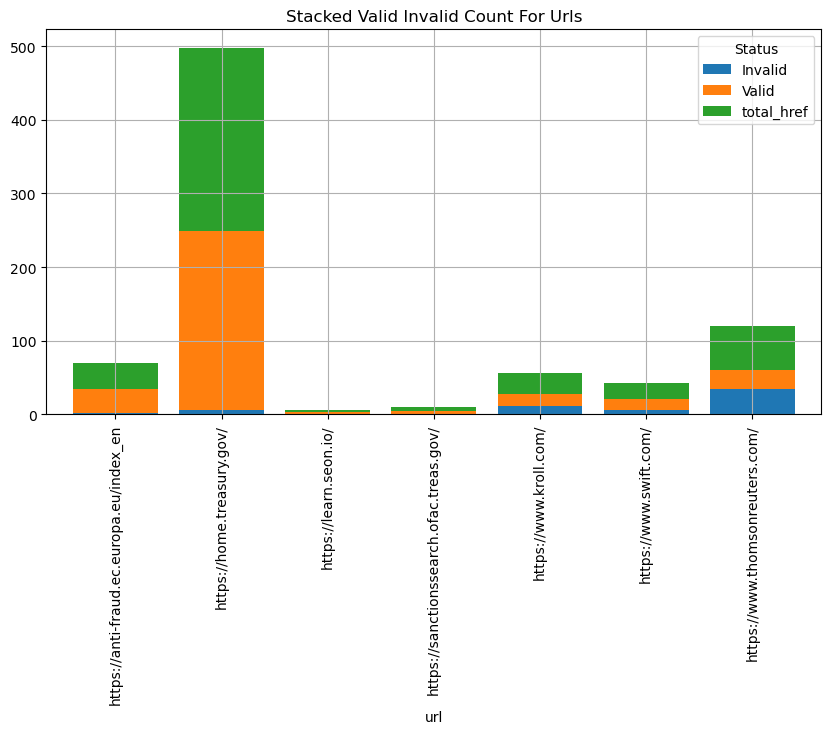

In [ ]:
new_df.plot(kind = 'bar',stacked=True,title = 'Stacked Valid Invalid Count For Urls',figsize=(10,5),width=0.8)
plt.grid()

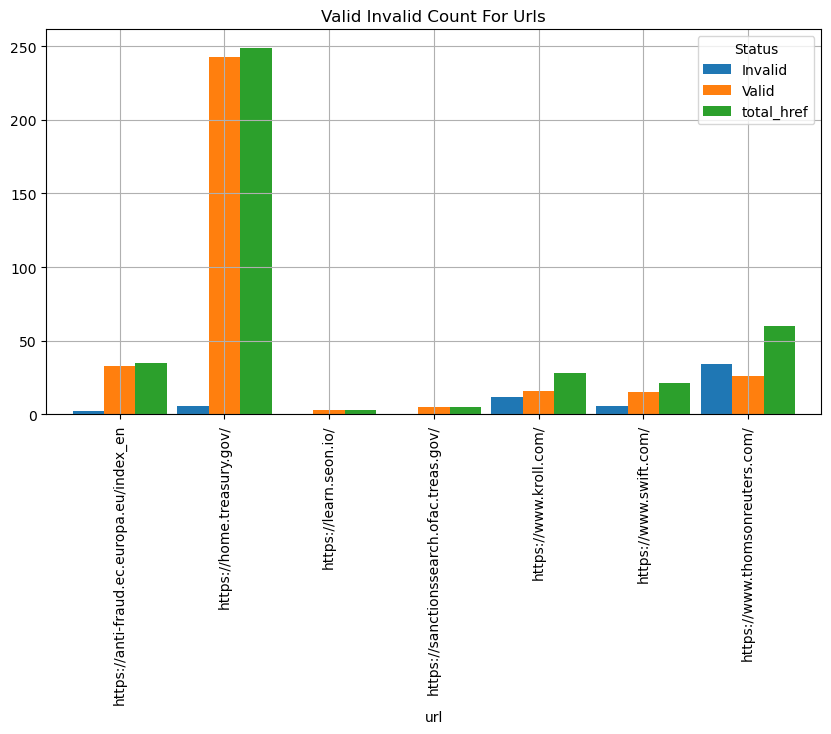

In [ ]:
new_df.plot(kind = 'bar',title = 'Valid Invalid Count For Urls',figsize=(10,5),width=0.9)
plt.grid()

### For each valid http/ https links or sub links find the website having the highest number of each keyword form list2 in Appendix. Group them by main link from list 1 and then the sub links. Make a csv file.

In [ ]:
keywords = ["Sanctions","OFAC","Foreign Sanctions","Balkans","ESG trends","Corporate income tax","European Parliament","customs fraud","Cybersecurity","OLAF","Device Fingerprinting"]

In [ ]:
df1 = pd.read_csv("/home/shubham/case/valid_href_timeout.csv")
df1 = df1[df1.Status=="Valid"]
df1[keywords]=np.nan

hrefs = list(df1.href)
for i in range(len(hrefs)):
    page = requests.get(hrefs[i])
    soup = BeautifulSoup(page.content, "html.parser")
    tag = soup.body
    text =""
    try:
        for string in tag.strings:
            text=text+string.strip()
        word_count = {word:text.count(word) for word in keywords}
        df1.loc[i,keywords] = word_count.values()    
    except:
        df1.loc[i,keywords] = 0
df1.to_csv("word_count.csv",index=False)

In [16]:
df1 = pd.read_csv("/content/drive/MyDrive/EKeeda/case/word_count.csv")
df1["max"]=df1.iloc[:,3:].idxmax(axis=1)
df1.head()

,url,href,Status,Sanctions,OFAC,Foreign Sanctions,Balkans,ESG trends,Corporate income tax,European Parliament,customs fraud,Cybersecurity,OLAF,Device Fingerprinting,max
0,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,39,24,0,0,0,0,0,0,0,0,0,Sanctions
1,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,35,23,1,0,0,0,0,0,0,0,0,Sanctions
2,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/office...,Valid,27,32,0,0,0,0,0,0,0,0,0,OFAC
3,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,49,12,4,1,0,0,0,0,0,0,0,Sanctions
4,https://sanctionssearch.ofac.treas.gov/,https://home.treasury.gov/policy-issues/financ...,Valid,23,21,0,0,0,0,0,0,0,0,0,Sanctions


In [25]:
aggregation_functions = {'max': 'first'}
df_new = df1.groupby(['url','href']).aggregate(aggregation_functions)
df_new.to_csv("/content/drive/MyDrive/EKeeda/case/Max_freq_keyword.csv",index=False)